In [1]:
import os, sys, mne, socket, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nilearn import plotting
from itertools import product

# Decoding tools
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    GeneralizingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

from initialization import load_paths
from preprocFuncs import getRawData, getTrials, remove_pulse
# from plotters import plotPower, plotRSA, plotDiffRSA
from decodeHelpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
subjID = 1
master_df =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/master_df_calib.csv')
day = 1 #master_df[(master_df['subjID'] == 1) & (master_df['istms']==0)]['day'].unique()[0]
p = load_paths(subjID, day)
# Load behavioral data
behav_df = master_df[(master_df['subjID'] == subjID) & (master_df['day'] == day)]
# Load raw data
# raw_data = getRawData(p)
montage = mne.channels.make_standard_montage("easycap-M1")
f_list = os.listdir(p['EEGfiles'])
f_list = [f for f in f_list if f.endswith('.vhdr')]
if len(f_list) == 1:
    raw_data = mne.io.read_raw_brainvision(p['EEGfiles'] + '/' + f_list[0], preload=True)
    raw_data.drop_channels(['LM', 'RM'])
    raw_data.set_montage(montage)

# Define events
events, tah = mne.events_from_annotations(raw_data)
events_dict = {
    'BlockStart': 1001,
    'Fixation': 1,
    'Delay1': 2,
    'Delay2': 3,
    'Response': 4,
    'Feedback': 6,
    'ITI': 7,
    'BlockEnd': 8,
}
trl_events = {
    'pro_inPF': 11,
    'pro_outPF': 12,
    'anti_inPF': 13,
    'anti_outPF': 14
}

# Define electrodes of interest
left_occ_elecs = ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P7']
right_occ_elecs = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P8']
left_par_elecs = ['P7', 'P5', 'P3', 'CP5', 'CP3', 'CP1', 'C5', 'C3', 'C1']
right_par_elecs = ['P8', 'P6', 'P4', 'CP6', 'CP4', 'CP2', 'C6', 'C4', 'C2']

left_elecs = ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P7', 'P5', 'CP5', 'CP3', 'CP1', 'C5', 'C3', 'C1']
right_elecs = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P8', 'P6', 'CP6', 'CP4', 'CP2', 'C6', 'C4', 'C2']

left_occ_elecs = [elec for elec in left_occ_elecs if elec in raw_data.ch_names]
right_occ_elecs = [elec for elec in right_occ_elecs if elec in raw_data.ch_names]
left_par_elecs = [elec for elec in left_par_elecs if elec in raw_data.ch_names]
right_par_elecs = [elec for elec in right_par_elecs if elec in raw_data.ch_names]
left_elecs = [elec for elec in left_elecs if elec in raw_data.ch_names]
right_elecs = [elec for elec in right_elecs if elec in raw_data.ch_names]

Extracting parameters from /d/DATD/datd/MD_TMS_EEG/EEGfiles/sub01/day01/sub01_day01.vhdr...
Setting channel info structure...
Reading 0 ... 4276619  =      0.000 ...  4276.619 secs...
Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']


In [18]:
cleaned_data = remove_pulse(raw_data)
cleaned_data.filter(l_freq=0.5, h_freq=55, verbose=False, n_jobs=-1)

Used Annotations descriptions: ['Response/R  1', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14']
Found 400 pulse events
Creating RawArray with float64 data, n_channels=63, n_times=4276620
    Range : 0 ... 4276619 =      0.000 ...  4276.619 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,66 points
Good channels,63 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.50 Hz
Lowpass,55.00 Hz


In [50]:
epochData = mne.Epochs(cleaned_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=None, preload=True)
epochDataBasecorr = mne.Epochs(cleaned_data, events, event_id=trl_events, tmin=-1, tmax=4.5, baseline=(-1, 0), preload=True)
proInPF = epochData.events[:, 2] == trl_events['pro_inPF']
proOutPF = epochData.events[:, 2] == trl_events['pro_outPF']
antiInPF = epochData.events[:, 2] == trl_events['anti_inPF']
antiOutPF = epochData.events[:, 2] == trl_events['anti_outPF']

Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 5501 original time points ...
0 bad epochs dropped


/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_74329/163614295.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


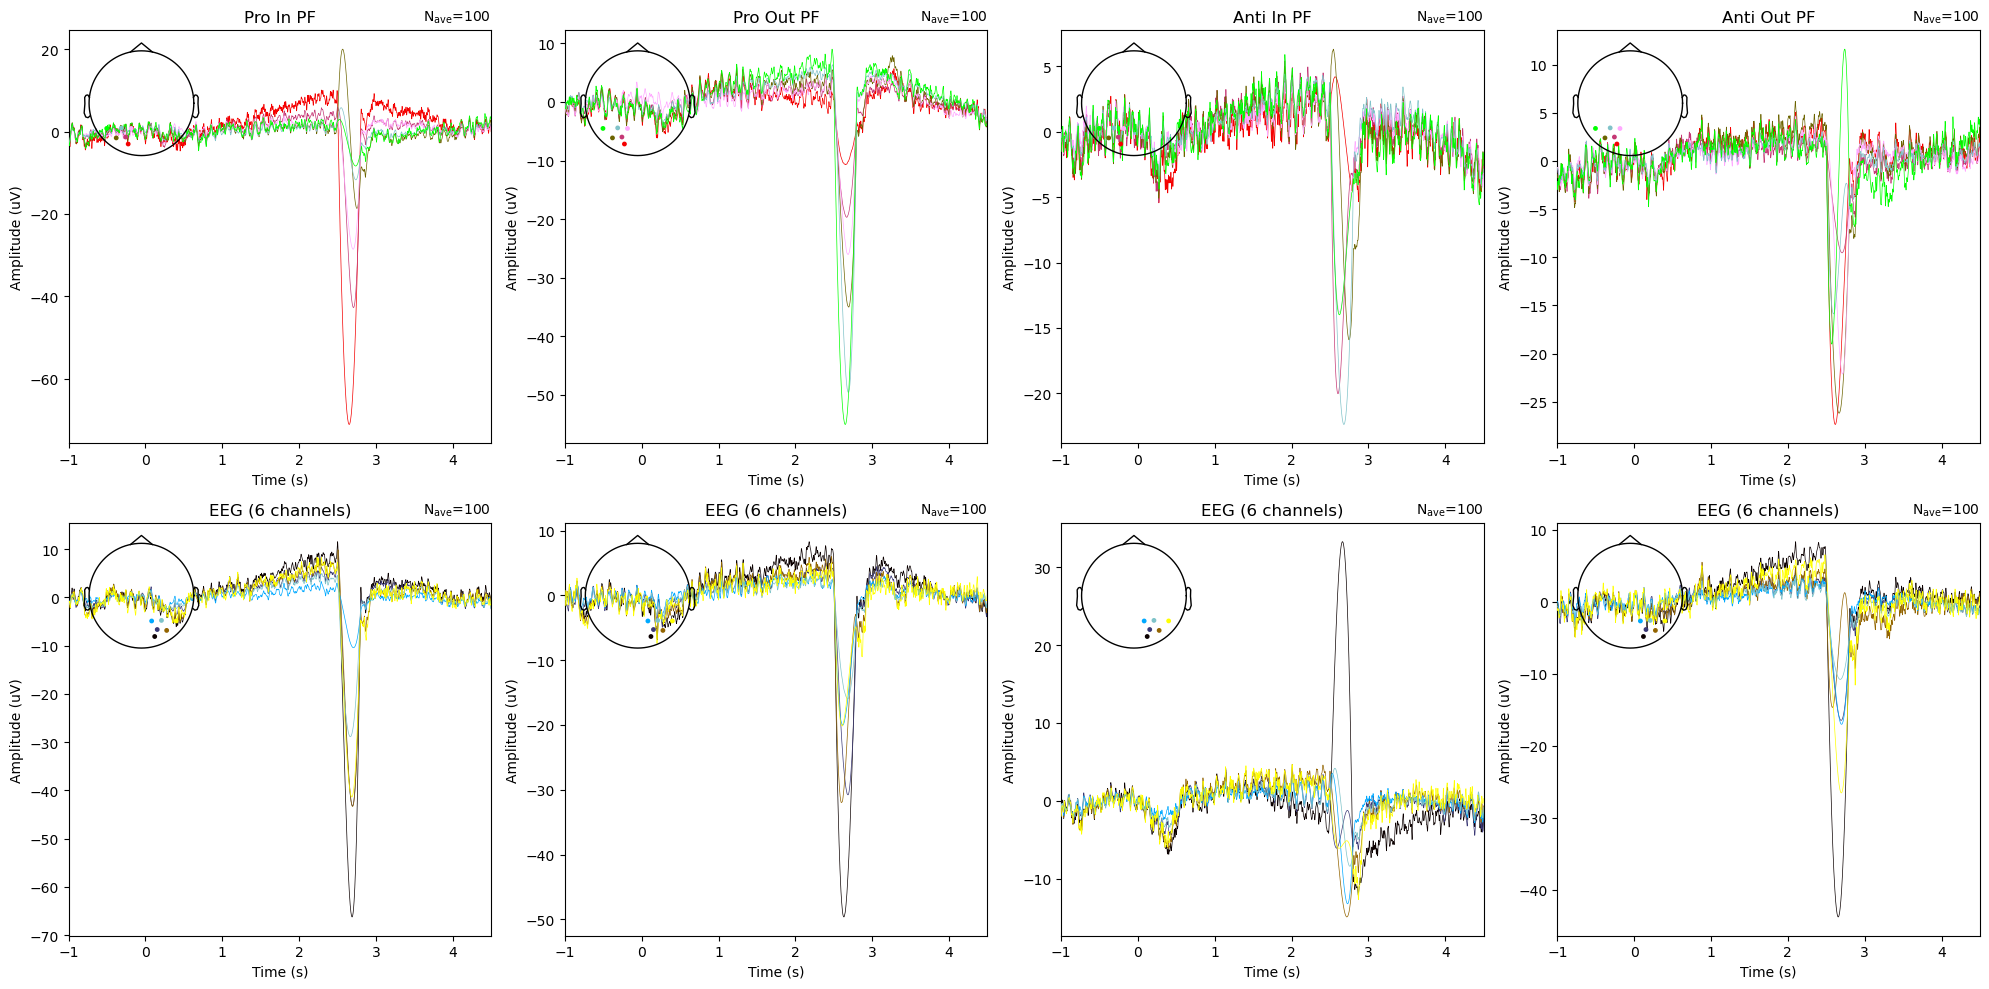

In [20]:
erpData = epochData.copy()#.filter(l_freq=0.1, h_freq=6, n_jobs=-1, verbose=False)

evoked_proInPF = erpData[proInPF].average()
evoked_proOutPF = erpData[proOutPF].average()
evoked_antiInPF = erpData[antiInPF].average()
evoked_antiOutPF = erpData[antiOutPF].average()
f, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
evoked_proInPF.plot(picks=left_occ_elecs, show=False, axes=axs[0])
evoked_proOutPF.plot(picks=left_occ_elecs, show=False, axes=axs[1])
evoked_antiInPF.plot(picks=left_occ_elecs, show=False, axes=axs[2])
evoked_antiOutPF.plot(picks=left_occ_elecs, show=False, axes=axs[3])

evoked_proInPF.plot(picks=right_occ_elecs, show=False, axes=axs[4])
evoked_proOutPF.plot(picks=right_occ_elecs, show=False, axes=axs[5])
evoked_antiInPF.plot(picks=right_occ_elecs, show=False, axes=axs[6])
evoked_antiOutPF.plot(picks=right_occ_elecs, show=False, axes=axs[7])
for ax in axs:
    # ax.set_ylim
    ax.set_ylabel('Amplitude (uV)')
    ax.set_xlabel('Time (s)')
    # ax.text(
axs[0].set_title('Pro In PF')
axs[1].set_title('Pro Out PF')
axs[2].set_title('Anti In PF')
axs[3].set_title('Anti Out PF')
plt.tight_layout()
plt.show()

Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 10512 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 24208 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 25200 out of 25200 | elapsed:   10.0s finished


IndexError: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 200

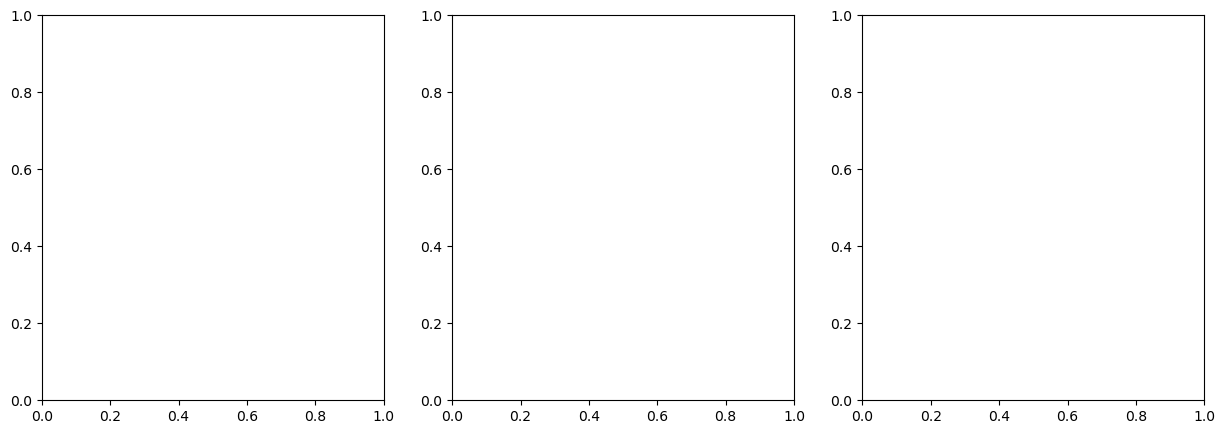

In [51]:
from scipy.signal import hilbert
w_size = 1.5
down_wsize = 50
freq_band = 'alpha'
pow_or_phase = 'pow'
if freq_band == 'alpha':
    lf, hf = 8, 14
elif freq_band == 'beta':
    lf, hf = 14, 20
elif freq_band == 'theta':
    lf, hf = 4, 8

t_array = epochData.times
# X = epochData.get_data(copy=True)
tempData = epochData.get_data(copy=True)

# tempData = (tempData - tempData.mean(axis=0)) / tempData.std(axis=0)
X = mne.filter.filter_data(tempData, sfreq=epochData.info['sfreq'], l_freq=lf, h_freq=hf, verbose=True, n_jobs=-1)
if pow_or_phase == 'pow':
    X = np.abs(hilbert(X)) ** 2
elif pow_or_phase == 'phase':
    X = np.angle(hilbert(X))

occ_elecs =  left_occ_elecs + right_occ_elecs 
# occ_elecs = left_par_elecs + right_par_elecs 
# occ_elecs = left_elecs + right_elecs
occElecsIdx = [epochDataBasecorr.ch_names.index(elec) for elec in occ_elecs]
X = X[:, occElecsIdx, :]
# X = np.log10(X)
y = epochData.events[:, 2].copy()
X_pro = X[(y==11) | (y==12), :, :]
y_pro = y[(y==11) | (y==12)]

y_hemi_stim = np.array([1 if y_pro == 11 else 0 for y_pro in y_pro]) # 1 for inPF, 0 for outPF
# y_hemi_stim = np.array([1 if y == 11 or y == 13 else 0 for y in y]) # 1 for inPF, 0 for outPF
y_hemi_resp = np.array([1 if y == 11 or y == 14 else 0 for y in y]) # 1 for pro inPF and anti outPF, 0 for pro outPF and anti inPF
y_trltype = np.array([0 if y == 11 or y == 12 else 1 for y in y]) # 0 for pro, 1 for anti


c1_trls = y_hemi_stim == 1
c2_trls = y_hemi_stim == 0

# X_down, t_array_down = moving_average_downsample(X, t_array, window_size=down_wsize)
X_down, t_array_down = X_pro[:, :, down_wsize:-down_wsize:down_wsize], t_array[down_wsize:-down_wsize:down_wsize]
# X_smooth = smooth_data(X, window_size=w_size)
X_smooth = gaussian_smooth_1d(X_down, sigma=w_size)

if pow_or_phase == 'pow':
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(t_array, X[c1_trls, :, :].mean(axis=(0,1)), label='cat1')
    ax[0].plot(t_array, X[c2_trls, :, :].mean(axis=(0,1)), label='cat2')
    ax[1].plot(t_array_down, X_down[c1_trls, :, :].mean(axis=(0,1)), label='cat1')
    ax[1].plot(t_array_down, X_down[c2_trls, :, :].mean(axis=(0,1)), label='cat2')
    ax[2].plot(t_array_down, X_smooth[c1_trls, :, :].mean(axis=(0,1)), label='cat1')
    ax[2].plot(t_array_down, X_smooth[c2_trls, :, :].mean(axis=(0,1)), label='cat2')
    plt.legend()
    plt.show()
else:
    from scipy.stats import circmean
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(t_array, circmean(X[c1_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat1')
    ax[0].plot(t_array, circmean(X[c2_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat2')
    ax[1].plot(t_array_down, circmean(X_down[c1_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat1')
    ax[1].plot(t_array_down, circmean(X_down[c2_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat2')
    ax[2].plot(t_array_down, circmean(X_smooth[c1_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat1')
    ax[2].plot(t_array_down, circmean(X_smooth[c2_trls, :, :], axis=(0,1), high=np.pi, low=-np.pi), label='cat2')
    plt.legend()
    plt.show()

In [52]:
from sklearn.svm import SVC

clf_temporal = make_pipeline(
    Vectorizer(),
    StandardScaler(),
    # LogisticRegression(solver='liblinear'),
    # LinearModel(LogisticRegression(solver='liblinear')),
    SVC(kernel='rbf', C=1),
    # SVC(kernel='rbf', C=1, decision_function_shape='ovr', probability=True),
)

gen_decod = GeneralizingEstimator(clf_temporal, n_jobs=-1, scoring='roc_auc', verbose=True)
# gen_decod = GeneralizingEstimator(clf_temporal, n_jobs=4, scoring='roc_auc_ovr', verbose=True)

# scores = cross_val_multiscore(gen_decod, X_smooth, y_ori_cat, cv=5, n_jobs=-1)
# create dummies for y_ori
y_ori_dum = pd.Categorical(y).codes

scores = cross_val_multiscore(gen_decod, X_smooth, y_hemi_stim, cv=5, n_jobs=-1)

scores_mean = np.mean(scores, axis=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.








  0%|          | Fitting GeneralizingEstimator : 0/109 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/109 [00:00<?,       ?it/s]
 11%|█         | Fitting GeneralizingEstimator : 12/109 [00:00<00:01,   84.72it/s]


 11%|█         | Fitting GeneralizingEstimator : 12/109 [00:00<00:01,   84.65it/s]

 11%|█         | Fitting GeneralizingEstimator : 12/109 [00:00<00:01,   80.55it/s]



 12%|█▏        | Fitting GeneralizingEstimator : 13/109 [00:00<00:01,   86.59it/s]


 28%|██▊       | Fitting GeneralizingEstimator : 30/109 [00:00<00:00,  168.49it/s]


 32%|███▏      | Fitting GeneralizingEstimator : 35/109 [00:00<00:00,  192.45it/s]



 39%|███▊      | Fitting GeneralizingEstimator : 42/109 [00:00<00:00,  203.24it/s]

 50%|█████     | Fitting GeneralizingEstimator : 55/109 [00:00<00:00,  252.54it/s]


 50%|█████     | Fitting GeneralizingEstimator : 55/109 [00:00<00:00,  243.45it

In [38]:
noTMS_scores = np.load('scores_mean_NoTMS.npy')

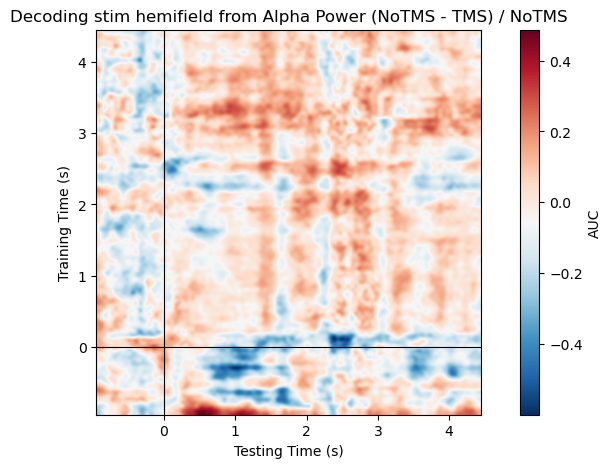

In [53]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow((noTMS_scores - scores_mean) / (noTMS_scores), 
               interpolation='lanczos', 
               origin='lower', 
               cmap='RdBu_r', 
               extent=[t_array_down[0], t_array_down[-1], t_array_down[0], t_array_down[-1]],
               )
ax.axhline(0, color='k', lw=0.8)
ax.axvline(0, color='k', lw=0.8)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
# ax.set_title('Decoding Hemifield from ERP')
ax.set_title('Decoding stim hemifield from Alpha Power (NoTMS - TMS) / NoTMS')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')
plt.show()

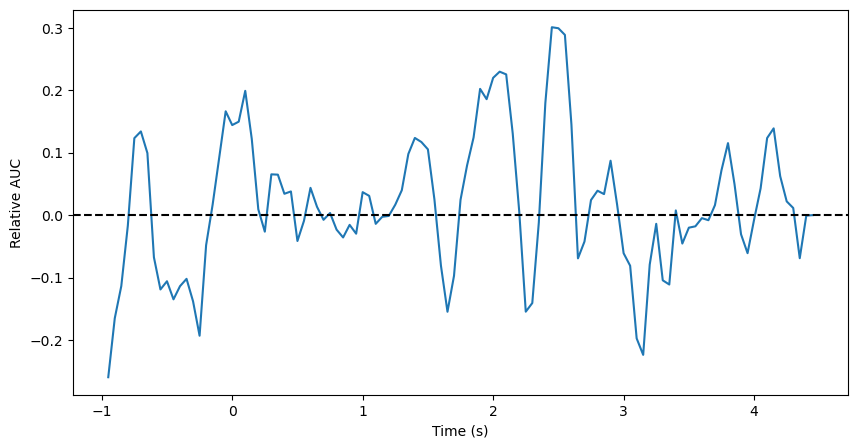

In [54]:
plt.figure(figsize=(10, 5))
aaha =(noTMS_scores - scores_mean) / (noTMS_scores)
plt.plot(t_array_down, aaha.diagonal(), label='Diagonal')
plt.axhline(0, color='k', linestyle='--', label='Chance')
plt.xlabel('Time (s)')
plt.ylabel('Relative AUC')
# plt.title('Decoding Hemifield from Alpha Power')
plt.show()